In [1]:
import seisbench
import seisbench.util
from base import BenchmarkDataset, WaveformDataWriter

from pathlib import Path
import h5py
import pandas as pd
import numpy as np

/mnt/nas4/weiwei/.pyenv/versions/SeisBench/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### CWBSN (目前只用 2020 為例)

In [2]:
class CWBSN(BenchmarkDataset):
    
    def __init__(self, **kwargs):
        # ======================= #
        # TODO: citation, license #
        # ======================= #
        citation = ()
        license = ""
        super().__init__(citation=citation, license=license, **kwargs)
    
    def _download_dataset(self, writer: WaveformDataWriter, basepath=None, **kwargs):
        path = self.path
        
        # CWBSN: containing 2012~2021
#         years = [str(y) for y in range(2012, 2022)]
        years = ['2020']
        
        if basepath is None:
            raise ValueError(
                "No cached version of CWBSN found. "
            )

        basepath = Path(basepath)

        # ========================== #
        # TODO: 檢查有沒有十年份的資料 #
        # ========================== #
        if not (basepath / "metadata_2020.csv").is_file():
            raise ValueError(
                "Basepath does not contain file metadata_2020.csv. "
            )
        if not (basepath / "chunks_2020.hdf5").is_file():
            raise ValueError(
                "Basepath does not contain file chunks_2020.hdf5. "
            )
            
        # Data format
        writer.data_format = {
            "dimension_order": "CW",
            "component_order": "ZNE",
            "sampling_rate": 100,
            "measurement": "velocity/acceleration",
            "unit": "cmps/cmps2",
        }
        # ============================================= #
        # TODO: 之後上傳檔案到網路上後，新增下載方式的 code
        # ============================================= #
    
        # =============================================== #
        # TODO: 統計 2012~2021 的 metadata 總共有幾個 rows: 
        #         writer.set_total(len(metadata))         #
        # =============================================== #
    
        total_trace = 0
        for y in years:
            # Loading metadata (ex. 2020)，之後一次 load 所有年份的資料進來
            metadata = pd.read_csv(basepath / "metadata_" + y + ".csv")

            metadata['split'] = self.set_split(y)

            # Adding traces (ex. 2020)，之後一次 load 所有年份的資料進來
            with h5py.File(basepath / "chunks_" + y + ".hdf5") as f:
                gdata = f["data"]
                for _, row in metadata.iterrows():
                    row = row.to_dict()
                    
                    # Adding trace only when waveform is available
                    if row['trace_completeness'] == 1:
                        waveforms = gdata[row["trace_name"]][()]
    
                        writer.add_trace(row, waveforms)
                        total_trace += 1
            
        # Total number of traces
        writer.set_total(total_trace)
        
    @staticmethod
    def set_split(year):
        if year == '2021':
            return 'test'
        elif year == '2020':
            return "dev"
        else:
            return 'train'
        
    # ==================================================== #
    # TODO: function -> 只選一個 trace 只包含一個事件的 case #
    # ==================================================== #
    
    # ======================================= #
    # TODO: 依照 trace_name，去依照事件來 load #
    # ======================================= #

In [3]:
# chunks = [str(y) for y in range(2012,2022)]
kwargs={'download_kwargs': {'basepath': '/mnt/nas2/CWBSN_modify_time/seisbench/'}}
data = CWBSN(**kwargs)

### 測試區

In [73]:
generator = sbg.GenericGenerator(data)
# generator.augmentation(sbg.RandomWindow(windowlen=5000))
# generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
generator.augmentation(sbg.ProbabilisticLabeller(label_columns=["trace_p_arrival_sample"], sigma=50, dim=-2))
# generator.augmentation(sbg.GaussianNoise())
generator.augmentation(sbg.ChannelDropout())
generator.augmentation(sbg.AddGap())

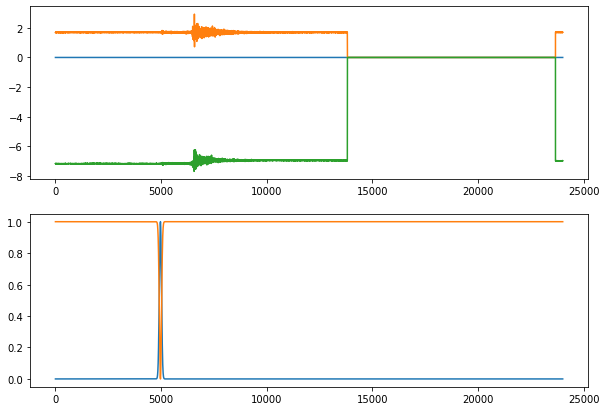

In [74]:
sample = generator[3000]
fig = plt.figure(figsize=(10, 7))
axs = fig.subplots(2, 1)
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)

In [75]:
df = pd.read_csv("/mnt/nas2/CWBSN_modify_time/seisbench/metadata_2020.csv")

In [77]:
type(df['trace_completeness'].iloc[0])

numpy.int64